In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, dimension, sequence)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    X_train = X_train.transpose((0,2,1))
    X_valid = X_valid.transpose((0,2,1))
    X_test = X_test.transpose((0,2,1))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
# 뒷 padding 제거
class Chomp1d(torch.nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

In [11]:
class CausalConvolutionBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,dilation, final = False):
        super().__init__()

        padding = (kernel_size - 1) * dilation

        conv1 = nn.utils.weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp1 = Chomp1d(padding)
        relu1 = nn.LeakyReLU()

        conv2 = nn.utils.weight_norm(nn.Conv1d(out_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp2 = Chomp1d(padding)
        relu2 = nn.LeakyReLU()

        # Causal network
        self.causal = torch.nn.Sequential(
            conv1, chomp1, relu1, conv2, chomp2, relu2
        )

        # Residual connection
        self.upordownsample = torch.nn.Conv1d(
            in_channels, out_channels, 1
        ) if in_channels != out_channels else None

        # Final activation function
        self.relu = torch.nn.LeakyReLU() if final else None

    def forward(self, x):
        out_causal = self.causal(x)
        res = x if self.upordownsample is None else self.upordownsample(x)
        if self.relu is None:
            return out_causal + res
        else:
            return self.relu(out_causal + res)


In [12]:
class CausalCNN(torch.nn.Module):
    def __init__(self, in_channels, channels, depth, out_channels,
                 kernel_size):
        super(CausalCNN, self).__init__()

        layers = []  # layer of convolution block
        dilation_size = 1  # initial setting

        for i in range(depth):
            in_channels_block = in_channels if i == 0 else channels
            layers += [CausalConvolutionBlock(
                in_channels_block, channels, kernel_size, dilation_size
            )]
            dilation_size *= 2  # 각 step이 지날수록 dilation이 2배로

        # last layer
        layers += [CausalConvolutionBlock(
            channels, out_channels, kernel_size, dilation_size
        )]

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [13]:
class SqueezeChannels(torch.nn.Module):
    def __init__(self):
        super(SqueezeChannels, self).__init__()

    def forward(self, x):
        return x.squeeze(2)

In [14]:
class CausalCNNEncoder(torch.nn.Module):
    '''
    (1,10,1056) tensor를 넣는다고 하자
    Causal_cnn(10,10,5,5,3)을 거치면 (1, 5, 1056)가 된다.
    AdaptiveMaxPool1d(1) 를 거치면 (1,5,1)이 된다.
    SqueezeChannels() 을 거치면 (1,5)가 된다.
    그 다음은 linear거쳐서 (1,2)가 되게 하고 이진 분류를 하면 된다.(마무리!!!!!!)
    '''
    def __init__(self, config):
        super(CausalCNNEncoder, self).__init__()
        causal_cnn = CausalCNN(
            config.in_channels, config.channels, config.depth, config.reduced_size, config.kernel_size
        )
        reduce_size = torch.nn.AdaptiveMaxPool1d(1)
        squeeze = SqueezeChannels()  # Squeezes the third dimension (time)
        linear = torch.nn.Linear(config.reduced_size, config.out_channels)
        self.network = torch.nn.Sequential(
            causal_cnn, reduce_size, squeeze, linear
        )

    def forward(self, x):
        return self.network(x.float())

# trainer 구현

In [15]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [16]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 5000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  in_channels = 19       # 처음 input의 차원의 개수 (feature수와 같다)
  channels = 19          # 중간의 차원
  depth = 5              # block 개수, block이 2이면 dilation도 2까지 한다고 생각하면 된다.
  reduced_size = 10      # 여러 block을 다 지나고 나온 차원의 개수
  out_channels = 2       # block거치고 linear 변환을 마친 차원의 개수, 여기가 2이면 이진분류
  kernel_size = 3        # kernel size인데 CasualCNNEncoder의 모든 커널의 size는 같다.

config = Config()

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [18]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [19]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


In [20]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 5000
failure(1)의 개수 : 1569


In [21]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [22]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [23]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [24]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 3941
Total number of data samples in valid_loader: 1313
Total number of data samples in test_loader: 1314


In [25]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [26]:
# model, optimizer, loss_function 구현하고 결합시키기
model = CausalCNNEncoder(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [28]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/5000_tcn') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Model saved
TRAIN LOSS = 0.002764785071975294, TRAIN ACC = 0.5851306774930221, 
VALID LOSS = 0.002606114992547017, VALID ACC = 0.76999238385377, 
epoch 2


100%|██████████| 6/6 [00:56<00:00,  9.44s/it]


Model saved
TRAIN LOSS = 0.0022498085939832765, TRAIN ACC = 0.7597056584623192, 
VALID LOSS = 0.002253067080337222, VALID ACC = 0.7707539984767707, 
epoch 3


100%|██████████| 6/6 [00:56<00:00,  9.35s/it]


Model saved
TRAIN LOSS = 0.00207081425767718, TRAIN ACC = 0.7640192844455722, 
VALID LOSS = 0.0021916063841480567, VALID ACC = 0.7776085300837776, 
epoch 4


100%|██████████| 6/6 [00:56<00:00,  9.34s/it]


Model saved
TRAIN LOSS = 0.001928556807843963, TRAIN ACC = 0.7802588175589952, 
VALID LOSS = 0.002019778677097097, VALID ACC = 0.785986290936786, 
epoch 5


100%|██████████| 6/6 [00:51<00:00,  8.52s/it]


Model saved
TRAIN LOSS = 0.0018325433214434934, TRAIN ACC = 0.7873636132961177, 
VALID LOSS = 0.0019445686011666664, VALID ACC = 0.8103579588728104, 
epoch 6


100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


Model saved
TRAIN LOSS = 0.0017269631534383794, TRAIN ACC = 0.8018269474752601, 
VALID LOSS = 0.0019249372235346821, VALID ACC = 0.8164508758568164, 
epoch 7


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


Model saved
TRAIN LOSS = 0.001626424523544505, TRAIN ACC = 0.8160365389495052, 
VALID LOSS = 0.0017749233638069055, VALID ACC = 0.821020563594821, 
epoch 8


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


TRAIN LOSS = 0.0015490804566129516, TRAIN ACC = 0.8183202232935803, 
VALID LOSS = 0.0017242033519730346, VALID ACC = 0.8095963442498096, 
epoch 9


100%|██████████| 6/6 [00:56<00:00,  9.44s/it]


TRAIN LOSS = 0.001462917586807913, TRAIN ACC = 0.824410048211114, 
VALID LOSS = 0.0017193926942321242, VALID ACC = 0.805026656511805, 
epoch 10


100%|██████████| 6/6 [00:55<00:00,  9.33s/it]


TRAIN LOSS = 0.0014043873078143708, TRAIN ACC = 0.8269474752600863, 
VALID LOSS = 0.0018064093017796025, VALID ACC = 0.817974105102818, 
epoch 11


100%|██████████| 6/6 [00:56<00:00,  9.38s/it]


TRAIN LOSS = 0.0013619216754030558, TRAIN ACC = 0.8332910428825171, 
VALID LOSS = 0.0016095802380851636, VALID ACC = 0.8095963442498096, 
epoch 12


100%|██████████| 6/6 [00:56<00:00,  9.40s/it]


Model saved
TRAIN LOSS = 0.001309984576063875, TRAIN ACC = 0.8434407510784065, 
VALID LOSS = 0.0015055114589205972, VALID ACC = 0.8324447829398325, 
epoch 13


100%|██████████| 6/6 [00:56<00:00,  9.38s/it]


TRAIN LOSS = 0.0012376888229047789, TRAIN ACC = 0.8523217457498097, 
VALID LOSS = 0.0014052861465902976, VALID ACC = 0.8301599390708302, 
epoch 14


100%|██████████| 6/6 [00:56<00:00,  9.41s/it]


Model saved
TRAIN LOSS = 0.0011545733558862412, TRAIN ACC = 0.8655163664044658, 
VALID LOSS = 0.0015497673402192116, VALID ACC = 0.8362528560548362, 
epoch 15


100%|██████████| 6/6 [00:56<00:00,  9.43s/it]


Model saved
TRAIN LOSS = 0.001125255693671849, TRAIN ACC = 0.8695762496828217, 
VALID LOSS = 0.0014473102356946297, VALID ACC = 0.8484386900228484, 
epoch 16


100%|██████████| 6/6 [00:56<00:00,  9.44s/it]


Model saved
TRAIN LOSS = 0.0010513921273719595, TRAIN ACC = 0.8817558995178889, 
VALID LOSS = 0.0013547052614396524, VALID ACC = 0.8575780654988576, 
epoch 17


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 0.0010370262320711359, TRAIN ACC = 0.8807409286982999, 
VALID LOSS = 0.0014318772290194206, VALID ACC = 0.8552932216298553, 
epoch 18


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


Model saved
TRAIN LOSS = 0.0009761948447577151, TRAIN ACC = 0.8911443795990865, 
VALID LOSS = 0.0013332766312637678, VALID ACC = 0.8728103579588729, 
epoch 19


100%|██████████| 6/6 [00:56<00:00,  9.37s/it]


Model saved
TRAIN LOSS = 0.0009415226255204889, TRAIN ACC = 0.8929205785333671, 
VALID LOSS = 0.0012580024451584826, VALID ACC = 0.8743335872048743, 
epoch 20


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


Model saved
TRAIN LOSS = 0.000871897178596423, TRAIN ACC = 0.9089063689418929, 
VALID LOSS = 0.0011817197012519982, VALID ACC = 0.8766184310738766, 
epoch 21


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


Model saved
TRAIN LOSS = 0.0008744586432110202, TRAIN ACC = 0.9033240294341538, 
VALID LOSS = 0.0011772294922448802, VALID ACC = 0.8827113480578828, 
epoch 22


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


Model saved
TRAIN LOSS = 0.0007889565705224603, TRAIN ACC = 0.9147424511545293, 
VALID LOSS = 0.001113876825239671, VALID ACC = 0.884996191926885, 
epoch 23


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


Model saved
TRAIN LOSS = 0.0007999263206613575, TRAIN ACC = 0.9152499365643237, 
VALID LOSS = 0.0010545358050441523, VALID ACC = 0.8903274942878904, 
epoch 24


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 0.0007448247379834384, TRAIN ACC = 0.9221009895965491, 
VALID LOSS = 0.0011074581131713588, VALID ACC = 0.8865194211728865, 
epoch 25


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 0.0006856747544437942, TRAIN ACC = 0.9264146155798021, 
VALID LOSS = 0.001298608132109602, VALID ACC = 0.8682406702208683, 
epoch 26


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


Model saved
TRAIN LOSS = 0.0006795225618182629, TRAIN ACC = 0.9281908145140827, 
VALID LOSS = 0.0012963056814007784, VALID ACC = 0.8956587966488957, 
epoch 27


100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


Model saved
TRAIN LOSS = 0.0006215863253101725, TRAIN ACC = 0.9330119259071302, 
VALID LOSS = 0.0010036047936756922, VALID ACC = 0.8964204112718964, 
epoch 28


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 0.0005709557923772135, TRAIN ACC = 0.9408779497589445, 
VALID LOSS = 0.0013637761986173933, VALID ACC = 0.884996191926885, 
epoch 29


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 0.0005576515263544366, TRAIN ACC = 0.9431616341030196, 
VALID LOSS = 0.0011616092507201847, VALID ACC = 0.8918507235338918, 
epoch 30


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 0.0005372311939778167, TRAIN ACC = 0.9429078913981223, 
VALID LOSS = 0.0011504890690844929, VALID ACC = 0.8956587966488957, 
epoch 31


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 0.0005206643752385081, TRAIN ACC = 0.9464602892666836, 
VALID LOSS = 0.0011593813966088683, VALID ACC = 0.8933739527798934, 
epoch 32


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 0.000483789731481601, TRAIN ACC = 0.9500126871352449, 
VALID LOSS = 0.001192575486579744, VALID ACC = 0.8910891089108911, 
epoch 33


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


Model saved
TRAIN LOSS = 0.000547033670105265, TRAIN ACC = 0.94037046434915, 
VALID LOSS = 0.0014154771108801638, VALID ACC = 0.897943640517898, 
epoch 34


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


Model saved
TRAIN LOSS = 0.00047110365758054726, TRAIN ACC = 0.9515351433646283, 
VALID LOSS = 0.0011642561758735755, VALID ACC = 0.900990099009901, 
epoch 35


100%|██████████| 6/6 [00:56<00:00,  9.36s/it]


TRAIN LOSS = 0.00044335506760024445, TRAIN ACC = 0.9538188277087034, 
VALID LOSS = 0.0012297877603510547, VALID ACC = 0.900990099009901, 
epoch 36


100%|██████████| 6/6 [00:55<00:00,  9.32s/it]


TRAIN LOSS = 0.0004027469834680032, TRAIN ACC = 0.9594011672164425, 
VALID LOSS = 0.0013505797279943334, VALID ACC = 0.8948971820258949, 
epoch 37


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 0.00039813583596228825, TRAIN ACC = 0.9606698807409287, 
VALID LOSS = 0.0013270335213791207, VALID ACC = 0.8948971820258949, 
epoch 38


100%|██████████| 6/6 [00:56<00:00,  9.44s/it]


TRAIN LOSS = 0.0004154606194128333, TRAIN ACC = 0.9571174828723674, 
VALID LOSS = 0.0013562971775711535, VALID ACC = 0.8857578065498858, 
epoch 39


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 0.0004211741286209167, TRAIN ACC = 0.9558487693478812, 
VALID LOSS = 0.0013894420131325995, VALID ACC = 0.897943640517898, 
epoch 40


100%|██████████| 6/6 [00:56<00:00,  9.44s/it]


TRAIN LOSS = 0.0003737359634059179, TRAIN ACC = 0.9609236234458259, 
VALID LOSS = 0.0013259457479609122, VALID ACC = 0.900990099009901, 
epoch 41


100%|██████████| 6/6 [00:56<00:00,  9.40s/it]


TRAIN LOSS = 0.00037148078930495927, TRAIN ACC = 0.9665059629535651, 
VALID LOSS = 0.0013330703415402182, VALID ACC = 0.8903274942878904, 
epoch 42


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


TRAIN LOSS = 0.0003377025385959836, TRAIN ACC = 0.9680284191829485, 
VALID LOSS = 0.0013782659152583683, VALID ACC = 0.8971820258948972, 
epoch 43


100%|██████████| 6/6 [00:56<00:00,  9.48s/it]


TRAIN LOSS = 0.00033681363385360696, TRAIN ACC = 0.9682821618878458, 
VALID LOSS = 0.0015558456861600564, VALID ACC = 0.8956587966488957, 
epoch 44


100%|██████████| 6/6 [00:56<00:00,  9.43s/it]


TRAIN LOSS = 0.00035260164761900207, TRAIN ACC = 0.963207307789901, 
VALID LOSS = 0.001414023572401699, VALID ACC = 0.8964204112718964, 
epoch 45


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


TRAIN LOSS = 0.0003948932538644156, TRAIN ACC = 0.9573712255772646, 
VALID LOSS = 0.0013754067478612098, VALID ACC = 0.8964204112718964, 
epoch 46


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 0.00029737515192109295, TRAIN ACC = 0.9710733316417153, 
VALID LOSS = 0.001465309317658534, VALID ACC = 0.8987052551408987, 
epoch 47


100%|██████████| 6/6 [00:56<00:00,  9.48s/it]


Model saved
TRAIN LOSS = 0.00030290632230078196, TRAIN ACC = 0.9705658462319209, 
VALID LOSS = 0.0013861368720257273, VALID ACC = 0.9078446306169079, 
epoch 48


100%|██████████| 6/6 [00:56<00:00,  9.44s/it]


TRAIN LOSS = 0.0003139184033075162, TRAIN ACC = 0.9677746764780513, 
VALID LOSS = 0.001618921211995156, VALID ACC = 0.8910891089108911, 
epoch 49


100%|██████████| 6/6 [00:56<00:00,  9.40s/it]


TRAIN LOSS = 0.00031879621675340574, TRAIN ACC = 0.9705658462319209, 
VALID LOSS = 0.0014145634756320682, VALID ACC = 0.8948971820258949, 
epoch 50


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


TRAIN LOSS = 0.00031233203933644915, TRAIN ACC = 0.9672671910682568, 
VALID LOSS = 0.0013525068124377445, VALID ACC = 0.8987052551408987, 
epoch 51


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


TRAIN LOSS = 0.00024367801739203992, TRAIN ACC = 0.9769094138543517, 
VALID LOSS = 0.0014460755956145705, VALID ACC = 0.904036557501904, 
epoch 52


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 0.00024145686480485373, TRAIN ACC = 0.9786856127886323, 
VALID LOSS = 0.0016560848101530926, VALID ACC = 0.9063214013709063, 
epoch 53


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 0.0001932053172862097, TRAIN ACC = 0.9840142095914742, 
VALID LOSS = 0.0015582981698856223, VALID ACC = 0.900990099009901, 
epoch 54


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 0.00017538722637597452, TRAIN ACC = 0.9832529814767825, 
VALID LOSS = 0.0015741543332221213, VALID ACC = 0.9055597867479056, 
epoch 55


100%|██████████| 6/6 [00:56<00:00,  9.48s/it]


TRAIN LOSS = 0.00016149700366658204, TRAIN ACC = 0.9847754377061659, 
VALID LOSS = 0.002145441656156251, VALID ACC = 0.9032749428789033, 
epoch 56


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 0.00015159537299684812, TRAIN ACC = 0.9862978939355493, 
VALID LOSS = 0.0020389815186691576, VALID ACC = 0.8971820258948972, 
epoch 57


100%|██████████| 6/6 [00:56<00:00,  9.35s/it]


TRAIN LOSS = 0.0002432568946395299, TRAIN ACC = 0.9786856127886323, 
VALID LOSS = 0.0015452800251923712, VALID ACC = 0.9055597867479056, 
epoch 58


100%|██████████| 6/6 [00:56<00:00,  9.48s/it]


Model saved
TRAIN LOSS = 0.0004295324932701604, TRAIN ACC = 0.9647297640192845, 
VALID LOSS = 0.0014838738606707885, VALID ACC = 0.9101294744859101, 
epoch 59


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 0.0003521397834621508, TRAIN ACC = 0.9670134483633596, 
VALID LOSS = 0.0014432290993114509, VALID ACC = 0.9002284843869002, 
epoch 60


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


TRAIN LOSS = 0.00023808143891165383, TRAIN ACC = 0.9781781273788379, 
VALID LOSS = 0.001359657292954357, VALID ACC = 0.8987052551408987, 
epoch 61


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


TRAIN LOSS = 0.00019669924068423705, TRAIN ACC = 0.9824917533620908, 
VALID LOSS = 0.001632612848318177, VALID ACC = 0.9032749428789033, 
epoch 62


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


Model saved
TRAIN LOSS = 0.00017662281777820318, TRAIN ACC = 0.9824917533620908, 
VALID LOSS = 0.0016215977692368008, VALID ACC = 0.9185072353389185, 
epoch 63


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 0.00013404241244341025, TRAIN ACC = 0.9888353209845216, 
VALID LOSS = 0.0016508534244245368, VALID ACC = 0.9063214013709063, 
epoch 64


100%|██████████| 6/6 [00:56<00:00,  9.43s/it]


TRAIN LOSS = 0.00013475958683282946, TRAIN ACC = 0.989089063689419, 
VALID LOSS = 0.0017330592947885088, VALID ACC = 0.904036557501904, 
epoch 65


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 0.00016081065863023038, TRAIN ACC = 0.9857904085257548, 
VALID LOSS = 0.0015860414082824231, VALID ACC = 0.9078446306169079, 
epoch 66


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 0.0001921994808708705, TRAIN ACC = 0.9829992387718853, 
VALID LOSS = 0.0018094210727289263, VALID ACC = 0.8971820258948972, 
epoch 67


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


TRAIN LOSS = 0.0001528240074832498, TRAIN ACC = 0.987059122050241, 
VALID LOSS = 0.0016144795083672784, VALID ACC = 0.9063214013709063, 
epoch 68


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 0.00011116074409030531, TRAIN ACC = 0.9895965490992134, 
VALID LOSS = 0.002154171239848547, VALID ACC = 0.897943640517898, 
epoch 69


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 7.784442323411488e-05, TRAIN ACC = 0.9939101750824664, 
VALID LOSS = 0.001766173096667331, VALID ACC = 0.8994668697638994, 
epoch 70


100%|██████████| 6/6 [00:56<00:00,  9.39s/it]


TRAIN LOSS = 7.766200713028734e-05, TRAIN ACC = 0.9926414615579802, 
VALID LOSS = 0.0018825149681399274, VALID ACC = 0.9086062452399086, 
epoch 71


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


TRAIN LOSS = 6.422871512031683e-05, TRAIN ACC = 0.9954326313118498, 
VALID LOSS = 0.0020996638590020256, VALID ACC = 0.9101294744859101, 
epoch 72


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 0.00015749717029641045, TRAIN ACC = 0.987059122050241, 
VALID LOSS = 0.0023662442708868884, VALID ACC = 0.9063214013709063, 
epoch 73


100%|██████████| 6/6 [00:56<00:00,  9.43s/it]


TRAIN LOSS = 0.00029750794685802327, TRAIN ACC = 0.9771631565592489, 
VALID LOSS = 0.0018923599258780207, VALID ACC = 0.8994668697638994, 
epoch 74


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


TRAIN LOSS = 0.000292786736153794, TRAIN ACC = 0.9743719868053794, 
VALID LOSS = 0.001463235945349328, VALID ACC = 0.8948971820258949, 
epoch 75


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


TRAIN LOSS = 0.00019630114364763168, TRAIN ACC = 0.9819842679522963, 
VALID LOSS = 0.0015582762366360776, VALID ACC = 0.9032749428789033, 
epoch 76


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 0.00011622341549644552, TRAIN ACC = 0.9921339761481858, 
VALID LOSS = 0.0018719308310942348, VALID ACC = 0.9078446306169079, 
epoch 77


100%|██████████| 6/6 [00:57<00:00,  9.51s/it]


TRAIN LOSS = 0.00013143009090485594, TRAIN ACC = 0.989089063689419, 
VALID LOSS = 0.001968731157487345, VALID ACC = 0.9047981721249048, 
epoch 78


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 0.00015168220411624077, TRAIN ACC = 0.9857904085257548, 
VALID LOSS = 0.0022618438529314563, VALID ACC = 0.9032749428789033, 
epoch 79


100%|██████████| 6/6 [00:56<00:00,  9.38s/it]


TRAIN LOSS = 9.215356953644384e-05, TRAIN ACC = 0.9911190053285968, 
VALID LOSS = 0.001792153373349285, VALID ACC = 0.9101294744859101, 
epoch 80


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 8.820220794972052e-05, TRAIN ACC = 0.9911190053285968, 
VALID LOSS = 0.0022390530205644546, VALID ACC = 0.897943640517898, 
epoch 81


100%|██████████| 6/6 [00:56<00:00,  9.48s/it]


TRAIN LOSS = 8.676664663189953e-05, TRAIN ACC = 0.9931489469677747, 
VALID LOSS = 0.0020898521082689994, VALID ACC = 0.9116527037319117, 
epoch 82


100%|██████████| 6/6 [00:56<00:00,  9.50s/it]


TRAIN LOSS = 6.981698861849002e-05, TRAIN ACC = 0.9931489469677747, 
VALID LOSS = 0.0018863965901180885, VALID ACC = 0.9063214013709063, 
epoch 83


100%|██████████| 6/6 [00:56<00:00,  9.41s/it]


TRAIN LOSS = 0.000124957322326636, TRAIN ACC = 0.9911190053285968, 
VALID LOSS = 0.0019776548080923714, VALID ACC = 0.9131759329779132, 
epoch 84


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 0.00035126956425034374, TRAIN ACC = 0.9746257295102766, 
VALID LOSS = 0.0016743495595064766, VALID ACC = 0.9070830159939071, 
epoch 85


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 0.00019305015530600761, TRAIN ACC = 0.9822380106571936, 
VALID LOSS = 0.0019305032214769768, VALID ACC = 0.8971820258948972, 
epoch 86


100%|██████████| 6/6 [00:56<00:00,  9.41s/it]


TRAIN LOSS = 0.00012046234165614887, TRAIN ACC = 0.9895965490992134, 
VALID LOSS = 0.001771785744436806, VALID ACC = 0.9070830159939071, 
epoch 87


100%|██████████| 6/6 [00:56<00:00,  9.40s/it]


TRAIN LOSS = 6.955860627390231e-05, TRAIN ACC = 0.9944176604922609, 
VALID LOSS = 0.0019303196409868994, VALID ACC = 0.9070830159939071, 
epoch 88


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


TRAIN LOSS = 6.623386124900923e-05, TRAIN ACC = 0.9944176604922609, 
VALID LOSS = 0.0019352078573992484, VALID ACC = 0.9055597867479056, 
epoch 89


100%|██████████| 6/6 [00:56<00:00,  9.44s/it]


TRAIN LOSS = 6.192015905563706e-05, TRAIN ACC = 0.9959401167216443, 
VALID LOSS = 0.00219915452025269, VALID ACC = 0.9063214013709063, 
epoch 90


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 4.7423925266838174e-05, TRAIN ACC = 0.9972088302461304, 
VALID LOSS = 0.002140865217885804, VALID ACC = 0.9063214013709063, 
epoch 91


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


TRAIN LOSS = 4.065991958295579e-05, TRAIN ACC = 0.9982238010657194, 
VALID LOSS = 0.0021282037704479393, VALID ACC = 0.9101294744859101, 
epoch 92


100%|██████████| 6/6 [00:56<00:00,  9.41s/it]


TRAIN LOSS = 4.492739009425381e-05, TRAIN ACC = 0.9974625729510277, 
VALID LOSS = 0.0025396193608199016, VALID ACC = 0.9108910891089109, 
epoch 93


100%|██████████| 6/6 [00:56<00:00,  9.48s/it]


TRAIN LOSS = 3.5059997758506e-05, TRAIN ACC = 0.9974625729510277, 
VALID LOSS = 0.0027744124749191643, VALID ACC = 0.9017517136329017, 
epoch 94


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


TRAIN LOSS = 2.5204704935948154e-05, TRAIN ACC = 0.9987312864755138, 
VALID LOSS = 0.0023747953811131266, VALID ACC = 0.9070830159939071, 
epoch 95


100%|██████████| 6/6 [00:56<00:00,  9.41s/it]


TRAIN LOSS = 2.398515415307729e-05, TRAIN ACC = 0.9989850291804111, 
VALID LOSS = 0.0028568329197345395, VALID ACC = 0.9063214013709063, 
epoch 96


100%|██████████| 6/6 [00:56<00:00,  9.43s/it]


TRAIN LOSS = 1.5768919703005927e-05, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0022875725065399834, VALID ACC = 0.9108910891089109, 
epoch 97


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


TRAIN LOSS = 1.0655214756006927e-05, TRAIN ACC = 0.9994925145902055, 
VALID LOSS = 0.00228266597860929, VALID ACC = 0.9101294744859101, 
epoch 98


100%|██████████| 6/6 [00:56<00:00,  9.48s/it]


TRAIN LOSS = 1.0291151540084257e-05, TRAIN ACC = 0.9992387718853083, 
VALID LOSS = 0.002555855815862756, VALID ACC = 0.9086062452399086, 
epoch 99


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


TRAIN LOSS = 8.439440484317263e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0026830212359925942, VALID ACC = 0.9116527037319117, 
epoch 100


100%|██████████| 6/6 [00:56<00:00,  9.45s/it]


TRAIN LOSS = 7.568507338785424e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026919644294762014, VALID ACC = 0.9078446306169079, 
epoch 101


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


TRAIN LOSS = 6.383845461315063e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028296551764329155, VALID ACC = 0.9108910891089109, 
epoch 102


100%|██████████| 6/6 [00:56<00:00,  9.40s/it]


TRAIN LOSS = 6.259980127527323e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002673906809668094, VALID ACC = 0.9086062452399086, 
epoch 103


100%|██████████| 6/6 [00:56<00:00,  9.46s/it]


TRAIN LOSS = 5.63535687899554e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.002575390368575189, VALID ACC = 0.9093678598629094, 
epoch 104


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


TRAIN LOSS = 5.126793643334903e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033744100115268355, VALID ACC = 0.9086062452399086, 
epoch 105


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 4.9129839886364616e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030726350543159434, VALID ACC = 0.9078446306169079, 
epoch 106


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 6.223624222173406e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003153701593016997, VALID ACC = 0.9093678598629094, 
epoch 107


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 7.923733820182605e-06, TRAIN ACC = 0.9994925145902055, 
VALID LOSS = 0.003427122171290122, VALID ACC = 0.8994668697638994, 
epoch 108


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 0.0002828078040856924, TRAIN ACC = 0.9817305252473991, 
VALID LOSS = 0.00314528016715402, VALID ACC = 0.8948971820258949, 
epoch 109


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 0.0004258225545517777, TRAIN ACC = 0.9695508754123319, 
VALID LOSS = 0.0020656797691600884, VALID ACC = 0.8895658796648895, 
epoch 110


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 0.0002471473435707063, TRAIN ACC = 0.979446840903324, 
VALID LOSS = 0.0020289986712825453, VALID ACC = 0.900990099009901, 
epoch 111


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 0.00016031012154569242, TRAIN ACC = 0.987059122050241, 
VALID LOSS = 0.0014362421343549917, VALID ACC = 0.9025133282559025, 
epoch 112


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 7.60448356654114e-05, TRAIN ACC = 0.9946714031971581, 
VALID LOSS = 0.0016329267600612247, VALID ACC = 0.9070830159939071, 
epoch 113


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 4.480017848460316e-05, TRAIN ACC = 0.9977163156559249, 
VALID LOSS = 0.0021928324103809367, VALID ACC = 0.9025133282559025, 
epoch 114


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 3.123117190878106e-05, TRAIN ACC = 0.9989850291804111, 
VALID LOSS = 0.001859923128126599, VALID ACC = 0.9086062452399086, 
epoch 115


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 2.871060129978184e-05, TRAIN ACC = 0.9987312864755138, 
VALID LOSS = 0.0022447783803540336, VALID ACC = 0.9032749428789033, 
epoch 116


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


TRAIN LOSS = 2.3826157231809253e-05, TRAIN ACC = 0.9994925145902055, 
VALID LOSS = 0.0021262467134480064, VALID ACC = 0.9047981721249048, 
epoch 117


100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


TRAIN LOSS = 2.2827791764578844e-05, TRAIN ACC = 0.9987312864755138, 
VALID LOSS = 0.0028461436006919356, VALID ACC = 0.9078446306169079, 
epoch 118


100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


TRAIN LOSS = 1.3370848556451615e-05, TRAIN ACC = 0.9994925145902055, 
VALID LOSS = 0.002371951767441342, VALID ACC = 0.9063214013709063, 
epoch 119


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 9.455032960011463e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022720448042905157, VALID ACC = 0.9093678598629094, 
epoch 120


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 8.110633641963484e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002702258601047025, VALID ACC = 0.9086062452399086, 
epoch 121


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 7.30834833864549e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022051976433325976, VALID ACC = 0.9063214013709063, 
epoch 122


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 7.06667939117814e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.002694260751756202, VALID ACC = 0.9063214013709063, 
epoch 123


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 5.727973464730842e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025989261639544916, VALID ACC = 0.9086062452399086, 
epoch 124


100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


TRAIN LOSS = 4.704220034229335e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002464968583462171, VALID ACC = 0.9047981721249048, 
epoch 125


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 4.546547680644215e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002593644615901125, VALID ACC = 0.9063214013709063, 
epoch 126


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 4.310762514489042e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003071642521221222, VALID ACC = 0.9055597867479056, 
epoch 127


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 3.3899693675050918e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025551983262415796, VALID ACC = 0.9047981721249048, 
epoch 128


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 3.0248647609943478e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002902582367230987, VALID ACC = 0.9070830159939071, 
epoch 129


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 2.8489001219479174e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030949242407369505, VALID ACC = 0.9070830159939071, 
epoch 130


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 2.7817034169552296e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030226449156570143, VALID ACC = 0.9047981721249048, 
epoch 131


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


TRAIN LOSS = 2.5297753544821126e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002815754356406067, VALID ACC = 0.9063214013709063, 
epoch 132


100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


TRAIN LOSS = 2.309676924011694e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003027151989192338, VALID ACC = 0.9063214013709063, 
epoch 133


100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


TRAIN LOSS = 2.099156116620576e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036775353112841777, VALID ACC = 0.9055597867479056, 
epoch 134


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 2.0855604442601197e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.00280390097635535, VALID ACC = 0.9063214013709063, 
epoch 135


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 1.8396324824175045e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003469916263429245, VALID ACC = 0.9063214013709063, 
epoch 136


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 1.7706655282600467e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003594029521724239, VALID ACC = 0.9047981721249048, 
epoch 137


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 1.7814744663911839e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030695066048911936, VALID ACC = 0.9055597867479056, 
epoch 138


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 1.5829141517362371e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003970275330162193, VALID ACC = 0.9055597867479056, 
epoch 139


100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


TRAIN LOSS = 1.533706966703448e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036397932234921715, VALID ACC = 0.9070830159939071, 
epoch 140


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 1.4731336466068167e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036872957194023976, VALID ACC = 0.9047981721249048, 
epoch 141


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 1.4639338785361813e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003376233400684772, VALID ACC = 0.9055597867479056, 
epoch 142


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 1.3502950037942302e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003418025903273246, VALID ACC = 0.9047981721249048, 
epoch 143


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 1.2918644005976725e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003465397772858003, VALID ACC = 0.9032749428789033, 
epoch 144


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 1.1706789491430635e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003578230205239545, VALID ACC = 0.904036557501904, 
epoch 145


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 1.1350905696219375e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033509546077986844, VALID ACC = 0.9063214013709063, 
epoch 146


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 1.0896867201949497e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036942573421707794, VALID ACC = 0.9063214013709063, 
epoch 147


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 9.804930678488197e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003835943711230706, VALID ACC = 0.9055597867479056, 
epoch 148


100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


TRAIN LOSS = 9.702135557916126e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003358554676663122, VALID ACC = 0.9063214013709063, 
epoch 149


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 9.079846036326224e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004208863802929462, VALID ACC = 0.9032749428789033, 
epoch 150


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 8.839194762889855e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003851523448380458, VALID ACC = 0.9063214013709063, 
epoch 151


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 8.595673538651341e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004332862641188541, VALID ACC = 0.9055597867479056, 
epoch 152


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 8.3920648651466e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003710800195956902, VALID ACC = 0.9063214013709063, 
epoch 153


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 8.035981936520403e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0040393277196964054, VALID ACC = 0.9055597867479056, 
epoch 154


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


TRAIN LOSS = 7.435808685981352e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033216753354620952, VALID ACC = 0.9063214013709063, 
epoch 155


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 7.405419304033595e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033101394988159505, VALID ACC = 0.9055597867479056, 
epoch 156


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


TRAIN LOSS = 6.942921258222389e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005004048188587953, VALID ACC = 0.9055597867479056, 
epoch 157


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 6.989431234136407e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0037164772546482015, VALID ACC = 0.9055597867479056, 
epoch 158


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 6.659052836632158e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0035298187044496675, VALID ACC = 0.9055597867479056, 
epoch 159


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 6.633865505907579e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003392868317090548, VALID ACC = 0.9047981721249048, 
epoch 160


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 6.687614154999338e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003226948351587218, VALID ACC = 0.9055597867479056, 
epoch 161


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 6.382447458339056e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003624303142986312, VALID ACC = 0.9055597867479056, 
epoch 162


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 5.917054713130979e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0034803593785183535, VALID ACC = 0.9063214013709063, 
epoch 163


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 5.614621319213258e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003904081625695094, VALID ACC = 0.9063214013709063, 
epoch 164


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 5.465308533216013e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00507595451933141, VALID ACC = 0.9055597867479056, 
epoch 165


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 5.689333145002381e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003605956737993332, VALID ACC = 0.9055597867479056, 
epoch 166


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 5.251764725134333e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0039440547339533085, VALID ACC = 0.9055597867479056, 
epoch 167


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 4.876121129412644e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0037946750758171806, VALID ACC = 0.9055597867479056, 
epoch 168


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 4.786416150767647e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0034305851194391885, VALID ACC = 0.9055597867479056, 
epoch 169


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


TRAIN LOSS = 4.533847427395364e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003696895562685453, VALID ACC = 0.9055597867479056, 
epoch 170


100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


TRAIN LOSS = 4.506160793229876e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0035746356774538596, VALID ACC = 0.9055597867479056, 
epoch 171


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


TRAIN LOSS = 4.639073947393868e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004013493146409719, VALID ACC = 0.9055597867479056, 
epoch 172


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 4.162829695733236e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003935216223113154, VALID ACC = 0.9047981721249048, 
epoch 173


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 4.0828221322278796e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003582414128992817, VALID ACC = 0.9055597867479056, 
epoch 174


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 3.92313913578933e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004251832782268887, VALID ACC = 0.9055597867479056, 
epoch 175


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 3.8728967607022513e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0038327767661937937, VALID ACC = 0.9055597867479056, 
epoch 176


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 4.0270473015622494e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036817385736350695, VALID ACC = 0.9055597867479056, 
epoch 177


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 4.0148447950783454e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003818549913753559, VALID ACC = 0.9055597867479056, 
epoch 178


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 3.6766044308996953e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004153702972685211, VALID ACC = 0.9055597867479056, 
epoch 179


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 3.488391178765078e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004193028873463941, VALID ACC = 0.9063214013709063, 
epoch 180


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 3.4979884779464525e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0040668822024854554, VALID ACC = 0.9063214013709063, 
epoch 181


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 3.340906675587173e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0036580415282282137, VALID ACC = 0.9063214013709063, 
epoch 182


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 3.3588926891115225e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004267412383231332, VALID ACC = 0.9063214013709063, 
epoch 183


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 3.3372089599864874e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004648805163965276, VALID ACC = 0.9063214013709063, 
epoch 184


100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


TRAIN LOSS = 3.096027978004349e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004398742025350671, VALID ACC = 0.9055597867479056, 
epoch 185


100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


TRAIN LOSS = 3.0037807158897053e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003979887521094434, VALID ACC = 0.9055597867479056, 
epoch 186


100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


TRAIN LOSS = 2.8989221062295566e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003663625752571786, VALID ACC = 0.9055597867479056, 
epoch 187


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 2.893800822566827e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003746006067527312, VALID ACC = 0.9063214013709063, 
epoch 188


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 2.817193246113639e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0038970236731047676, VALID ACC = 0.9055597867479056, 
epoch 189


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 2.7061260577596216e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004133788438943716, VALID ACC = 0.9055597867479056, 
epoch 190


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 2.8812241424392626e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0039823676735412416, VALID ACC = 0.9055597867479056, 
epoch 191


100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


TRAIN LOSS = 2.6416095452652206e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0039411678808114955, VALID ACC = 0.9063214013709063, 
epoch 192


100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


TRAIN LOSS = 2.559931987019946e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0045676886899182565, VALID ACC = 0.9063214013709063, 
epoch 193


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]


TRAIN LOSS = 2.5156051076322286e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003907845048439567, VALID ACC = 0.9063214013709063, 
epoch 194


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 2.448102627797629e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005008905422387918, VALID ACC = 0.9055597867479056, 
epoch 195


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 2.4111792845222e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004324960781251394, VALID ACC = 0.9055597867479056, 
epoch 196


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 2.426086306545139e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004388446673489851, VALID ACC = 0.9055597867479056, 
epoch 197


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]


TRAIN LOSS = 2.3198681996207268e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0038637643948095223, VALID ACC = 0.9055597867479056, 
epoch 198


100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


TRAIN LOSS = 2.3427884907581515e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004877806799337325, VALID ACC = 0.9055597867479056, 
epoch 199


100%|██████████| 6/6 [00:28<00:00,  4.69s/it]


TRAIN LOSS = 2.2430551295206863e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003739526496756104, VALID ACC = 0.9055597867479056, 
epoch 200


100%|██████████| 6/6 [00:27<00:00,  4.66s/it]

TRAIN LOSS = 2.1441379965072537e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004063670361032943, VALID ACC = 0.9063214013709063, 


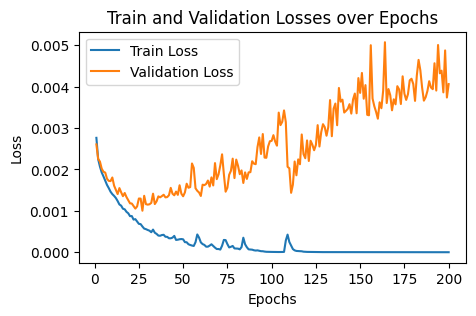

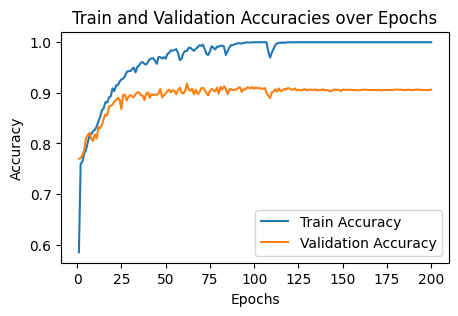

In [29]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH )
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH )

In [28]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/5000_tcn_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

Best epoch: 62
macro F1 Score: 0.873372220111176
AUROC: 0.9607095036310077
Accuracy: 0.906392694063927


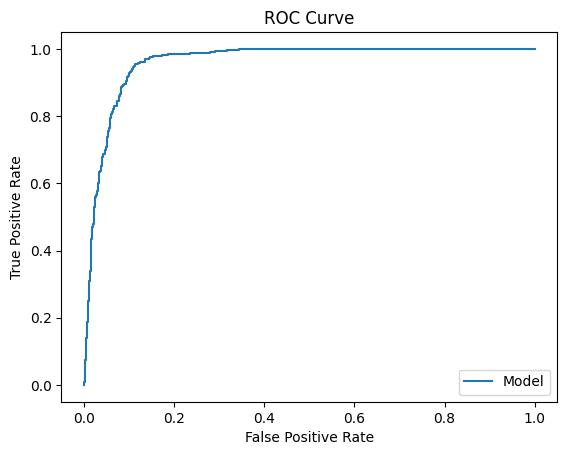

In [31]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)